In [1]:
import os

import datetime as dt
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

import configparser
import json

import modules.load_data as ld
from modules.modules_FIG03 import *
# paths
config = configparser.ConfigParser()
config.read("ConfigFile.ini")
pf = config['PATHS']['datasets']
ncfile_path = os.path.join(pf,"CAMSRA")


# filename templates
camsra_fname = "cams-ra_{date:%Y-%m-%d}_{levtype}.nc"


fname_AERONET = os.path.join(pf,'aeronet_sites.json')
path_AERONET = os.path.join(pf,'AERONET/')

fname_aerprop_dataset = os.path.join(pf,"test_TCARS2AERONET_{year}.nc")

with open(fname_AERONET) as txt:
    sites=json.load(txt)  
    
Aaod_AE_KEY = "440-870_Angstrom_Exponent"
Aaod_AOD_KEY = 'AOD_{wvl}nm'
Aall_AE_KEY = 'Angstrom_Exponent_440-870nm_from_Coincident_Input_AOD'
Aall_AAE_KEY = 'Absorption_Angstrom_Exponent_440-870nm'
Aall_AOD_KEY = 'AOD_Coincident_Input[{wvl}nm]'
Aall_AAOD_KEY = 'Absorption_AOD[{wvl}nm]'
Aall_G_KEY = 'Asymmetry_Factor-Total[{wvl}nm]'
Aall_REari_sfc = "Rad_Forcing(BOA)"
Aall_REari_toa = "Rad_Forcing(BOA)"



## collocation timeframe +-90min
cdt = np.timedelta64(90,'m')

def calc_ae(aod1,aod2,wvl1,wvl2):
    ae = -np.log(aod1/aod2)/np.log(wvl1/wvl2)
    return ae

def calc_aod(wvl,ae,aod2,wvl2):
    return aod2 * (wvl/wvl2)**(-ae)

def calc_aaod(aod,ssa):
    return aod*(1.-ssa)


## Collocation TCARS to AERONET
Here the calculated aerosol properties from the CAMSRA (which are already interpolated to the AERONET stations) are timewise collocated to the AERONET products. CAMSRA comes in a resolution of 3 hours. Therefore, the timewise closest pair of CAMSRA and AERONET datapoint is chosen for the results dataset.

## REari comparison
The REari from AERONET is measured at random times during clear sky within a day. Therefore, this dataset is not feasible to calculate a daily average value of REari. Regardless, to compare daily average REari, the daily mean of CAMSRA and AERONET collocated REari values are calculated and then scaled by the daily average calculated from the CAMSRA dataset (Fig07).

## Dataset
The dataset TCARS2AERONET_{year}.nc is calculated for the period from 2003 to 2019 to increase statistical robustness, apart from using only 2015 data. Regardless, the results of the evaluation of 2015 only data leads to similar results (RMSE,MBE ..) as for the complete period. To calculate TCARS2AERONET_{year}.nc for all years except 2015, one have to download the CAMSRA data from the Copernicus Atmospheric Data Storage, as the data provided here is 2015 exclusive.

In [2]:
## initialize results array
XAOD = np.array([])
XAE = np.array([])
XSSA = np.array([])
XG = np.array([])
XREari_sfc = np.array([])
XREari_toa = np.array([])
YAOD = np.array([])
YAE = np.array([])
YSSA = np.array([])
YG = np.array([])
YREari_sfc = np.array([])
YREari_toa = np.array([])

years = np.arange(2003,2020)
# for year in [2015]:
for year in years:
    print(f"Calculate year {year}")
    # open TCARS dataset, calcuated for AERONET sites
    TCARS = xr.open_dataset(fname_aerprop_dataset.format(year=year))

    # reshaped TCARS dataset (time,sites,wvl)
    dstimes,ind = np.unique(TCARS.time,return_index=True)
    dstimes = dstimes[np.argsort(ind)]
    dssites,ind = np.unique(TCARS.sites,return_index=True)
    dssites = dssites[np.argsort(ind)]
    newshape1=(len(dstimes),len(dssites))
    newshape2=(len(dstimes),len(dssites),TCARS.wvl.size)


    TCARS1 = xr.Dataset(dict(aod=(('time','sites','wvl'),TCARS.aod.values.reshape(newshape2)),
                              ssa=(('time','sites','wvl'),TCARS.ssa.values.reshape(newshape2)),
                              g=(('time','sites','wvl'),TCARS.g.values.reshape(newshape2)),
                              REari_sfc=(('time','sites'),TCARS.REari_sfc.values.reshape(newshape1)),
                              REari_toa=(('time','sites'),TCARS.REari_toa.values.reshape(newshape1)),
                             ),
                         coords=dict(time=('time',dstimes),
                                     sites=('sites',dssites),
                                     wvl=('wvl',TCARS.wvl)))


    # TCARS data without interpolated steps
    start = dt.date(pd.to_datetime(TCARS1.time.values[0]).year,1,1)
    stop = dt.date(pd.to_datetime(TCARS1.time.values[0]).year+1,1,1)
    cams_times = pd.date_range(start,stop,freq='3H')
    TCARS2 = TCARS1.interp(time=cams_times).dropna('time')

    for s,site in enumerate(sites):
        print(" >> ",site)
        # load aeronet data
        Aaod20,Aall15 = ld.load_aeronet(site,pf=path_AERONET)


        if type(Aaod20) != bool:
            ########################################################################
            ## collocate CAMS times to Aeronet

            removedouble=True
            Ctidx,Atidx = ld.closest_time(TCARS2.time.values,Aaod20['time'].values,
                                               dt=cdt,removedouble=removedouble)
            Taod20coll = TCARS2.sel(sites=site).isel(time=Ctidx)
            Aaod20coll = Aaod20.iloc[Atidx,:]

            ###################################################################
            ### calculate collocated aerosol properties
            T20_AE = calc_ae(Taod20coll.sel(wvl=440).aod,
                         Taod20coll.sel(wvl=865).aod,
                         440.,865.)

            T20_aod550 = Taod20coll.sel(wvl=550).aod.values

            A20_AE = Aaod20coll[Aaod_AE_KEY].values
            A20_aod550 = calc_aod(550.,A20_AE,
                                  Aaod20coll[Aaod_AOD_KEY.format(wvl=500)].values,500.)


            #################################################################
            # append to results arrays
            XAOD = np.concatenate((XAOD,A20_aod550),axis=0)
            XAE = np.concatenate((XAE,A20_AE),axis=0)
            YAOD = np.concatenate((YAOD,T20_aod550),axis=0)
            YAE = np.concatenate((YAE,T20_AE),axis=0)

        if type(Aall15) != bool:
            ########################################################################
            ## collocate CAMS times to Aeronet    
            Ctidx,Atidx = ld.closest_time(TCARS2.time.values,Aall15['time'].values,
                                               dt=cdt,removedouble=removedouble)
            Tall15coll = TCARS2.sel(sites=site).isel(time=Ctidx)
            Aall15coll = Aall15.iloc[Atidx,:]

            ###################################################################
            ### calculate collocated aerosol properties

            T15_ssa550 = Tall15coll.sel(wvl=550).ssa.values
            T15_g550 = Tall15coll.sel(wvl=550).g.values


            tmp_aaod550 = calc_aod(550.,Aall15coll[Aall_AAE_KEY].values,
                                   Aall15coll[Aall_AAOD_KEY.format(wvl=440)].values,440.)
            tmp_aod550 = calc_aod(550.,Aall15coll[Aall_AE_KEY].values,
                                  Aall15coll[Aall_AOD_KEY.format(wvl=440)].values,440.)
            A15_ssa550 = 1.- (tmp_aaod550 / tmp_aod550)

            gwvls = np.array([440,675,870,1020])
            gvalues = np.vstack((Aall15coll[Aall_G_KEY.format(wvl=440)].values,
                                 Aall15coll[Aall_G_KEY.format(wvl=675)].values,
                                 Aall15coll[Aall_G_KEY.format(wvl=870)].values,
                                 Aall15coll[Aall_G_KEY.format(wvl=1020)].values))
            gint = interp1d(gwvls,gvalues,axis=0)
            A15_g550 = gint(550.)





            #################################################################
            # append to results arrays
            XSSA = np.concatenate((XSSA,A15_ssa550),axis=0)
            XG = np.concatenate((XG,A15_g550),axis=0)

            YSSA = np.concatenate((YSSA,T15_ssa550),axis=0)
            YG = np.concatenate((YG,T15_g550),axis=0)


            ########################################################################
            ## collocate TCARS times (increased time resolutions) to Aeronet    
            Ctidx,Atidx = ld.closest_time(TCARS1.time.values,Aall15['time'].values,
                                               dt=cdt,removedouble=removedouble)
            T1all15coll = TCARS1.sel(sites=site).isel(time=Ctidx)
            A1all15coll = Aall15.iloc[Atidx,:]

            ###############################################################
            ## calculate daily mean REari
            ## AERONET measurements are not feasible to calculate daily averages
            ## Therefore, the daily mean is weighted by the ratio of
            ## T-CARS daily average to collocated daily mean
            Ttmp_REari_toa = T1all15coll.REari_toa.values
            Ttmp_REari_sfc = T1all15coll.REari_sfc.values
            Atmp_REari_toa = A1all15coll[Aall_REari_toa].values
            Atmp_REari_sfc = A1all15coll[Aall_REari_sfc].values


            T15_REari_toa = []
            T15_REari_sfc = []
            A15_REari_toa = []
            A15_REari_sfc = []
            for day in np.unique(T1all15coll.time.values.astype("datetime64[D]")):
                Tds = TCARS1.sel(sites=site,time=pd.to_datetime(day).strftime("%Y-%m-%d"))
                # Daily average REari (T-CARS)
                REari_toa = Tds.REari_toa.integrate('time',datetime_unit='D')
                REari_sfc = Tds.REari_sfc.integrate('time',datetime_unit='D')

                # Daily means of collocated datapoints
                idx = T1all15coll.time.values.astype("datetime64[D]") == day
                C_toa = REari_toa / np.mean(Ttmp_REari_toa[idx])
                C_sfc = REari_sfc / np.mean(Ttmp_REari_sfc[idx])
                T15_REari_toa.append(REari_toa)
                T15_REari_sfc.append(REari_sfc)
                A15_REari_toa.append(np.mean(Atmp_REari_toa[idx])*C_toa)
                A15_REari_sfc.append(np.mean(Atmp_REari_sfc[idx])*C_sfc)

            T15_REari_toa = np.array(T15_REari_toa)
            T15_REari_sfc = np.array(T15_REari_sfc)
            A15_REari_toa = np.array(A15_REari_toa)
            A15_REari_sfc = np.array(A15_REari_sfc)



            #################################################################
            # append to results arrays
            YREari_sfc = np.concatenate((YREari_sfc,T15_REari_sfc),axis=0)
            YREari_toa = np.concatenate((YREari_toa,T15_REari_toa),axis=0)
            XREari_sfc = np.concatenate((XREari_sfc,A15_REari_sfc),axis=0)
            XREari_toa = np.concatenate((XREari_toa,A15_REari_toa),axis=0)



    

Calculate year 2003
 >>  Mainz
 >>  Helgoland
 >>  Hamburg
 >>  MPI_Mainz
 >>  Leipzig
 >>  Munich_University
 >>  Munich_Maisach
 >>  Rossfeld
 >>  Laegeren
 >>  Karlsruhe
 >>  OBERNAI
 >>  Black_Forest_AMF
 >>  Buesum
 >>  FZJ-JOYCE
 >>  MetObs_Lindenberg
 >>  HOPE-Krauthausen
 >>  HOPE-Hambach
 >>  HOPE-Inselhombroich
 >>  HOPE-RWTH-Aachen
 >>  HohenpeissenbergDWD
 >>  HOPE-Melpitz
 >>  Berlin_FUB
 >>  KITcube_Karlsruhe
 >>  Melpitz
 >>  KEMPTEN_UAS
 >>  Zugspitze_KIT
Calculate year 2004
 >>  Mainz
 >>  Helgoland
 >>  Hamburg
 >>  MPI_Mainz
 >>  Leipzig
 >>  Munich_University
 >>  Munich_Maisach
 >>  Rossfeld
 >>  Laegeren
 >>  Karlsruhe
 >>  OBERNAI
 >>  Black_Forest_AMF
 >>  Buesum
 >>  FZJ-JOYCE
 >>  MetObs_Lindenberg
 >>  HOPE-Krauthausen
 >>  HOPE-Hambach
 >>  HOPE-Inselhombroich
 >>  HOPE-RWTH-Aachen
 >>  HohenpeissenbergDWD
 >>  HOPE-Melpitz
 >>  Berlin_FUB
 >>  KITcube_Karlsruhe
 >>  Melpitz
 >>  KEMPTEN_UAS
 >>  Zugspitze_KIT
Calculate year 2005
 >>  Mainz
 >>  Helgoland
 >

## Fig02 & Fig07
Here the figures 02 and 07 are produced. Note, that the "make_plotqq" has also options to plot a QQ-plot to compare the distributions of both CAMSRA and AERONET. 

In the figures directory, both figures are plotted also for the 2015 only dataset, for comparison.

/vols/fs1/satellite/home/jonas/documents/paper/2020_clearsky_aerosoleffect/code_publish/clear_sky_REari/modules/modules_FIG03.py:93: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(gridx[:-1]+0.5*(gridx[1:]-gridx[:-1]),Wgrid/Ngrid,color='k',linewidth=2,zorder=2)
/vols/fs1/satellite/home/jonas/documents/paper/2020_clearsky_aerosoleffect/code_publish/clear_sky_REari/modules/modules_FIG03.py:93: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(gridx[:-1]+0.5*(gridx[1:]-gridx[:-1]),Wgrid/Ngrid,color='k',linewidth=2,zorder=2)


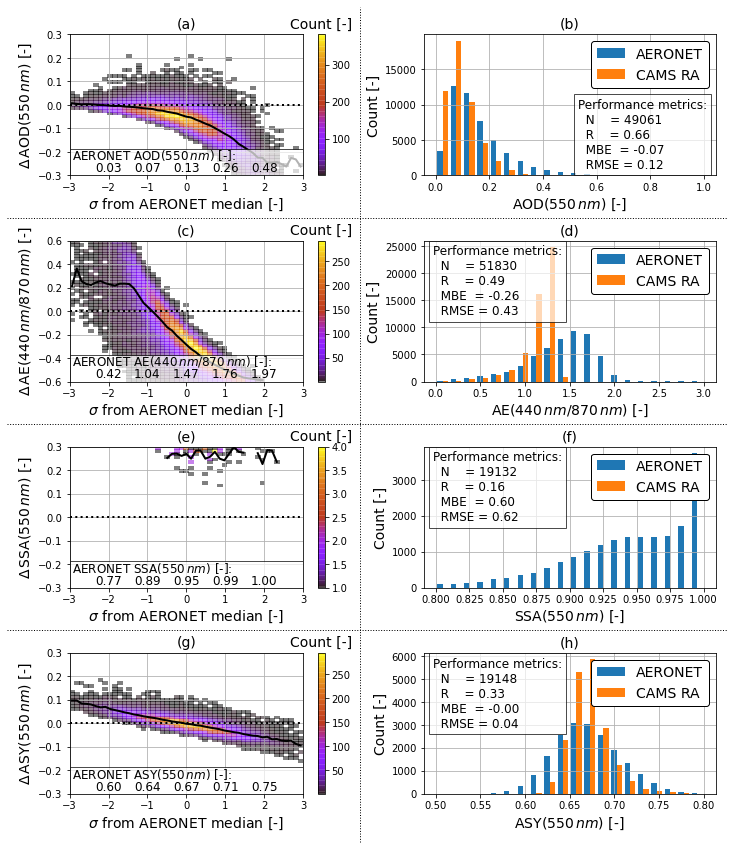

In [3]:
fig,axs = plt.subplots(4,2,figsize=(10,11.6))#(11,14)
fig = make_plotqq(fig=fig,
                X=XAOD,
                Y=YAOD,
                ax=axs[0,0],ax2=axs[0,1],
                W='counts', # histogram of number observations
                title='(a)',
                title2='(b)',
                Xlabel='AERONET',
                Ylabel='CAMS RA',
                Wlabel='Count [-]',
                Value=r'AOD(550$\,nm$) [-]',
                  lalpha=0.7,
                xlim=(-3,3),
                xlim2=(0,1),
                ylim=(-0.3,0.3),
                qqplot=False,
                percentiles=np.arange(0.5,100,0.5),
                histplot=True,
                metrics_loc=1)
fig = make_plotqq(fig=fig,
                X=XAE,
                Y=YAE,
                ax=axs[1,0],ax2=axs[1,1],
                W='counts', # histogram of number observations
                title='(c)',
                title2='(d)',
                Xlabel='AERONET',
                Ylabel='CAMS RA',
                Wlabel='Count [-]',
                Value=r'AE(440$\,nm$/870$\,nm$) [-]',
                  lalpha=0.7,
                xlim=(-3,3),
                xlim2=(0,3),
                ylim=(-0.6,0.6),
                qqplot=False,
                percentiles=np.arange(0.5,100,0.5),
                histplot=True,
                metrics_loc=0)
fig = make_plotqq(fig=fig,
                X=XSSA,
                Y=YSSA,
                ax=axs[2,0],ax2=axs[2,1],
                W='counts', # histogram of number observations
                title='(e)',
                title2='(f)',
                Xlabel='AERONET',
                Ylabel='CAMS RA',
                Wlabel='Count [-]',
                Value=r'SSA(550$\,nm$) [-]',
                  lalpha=0.7,
                xlim=(-3,3),
                xlim2=(0.8,1),
                ylim=(-0.3,0.3),
                qqplot=False,
                percentiles=np.arange(0.5,100,0.5),
                histplot=True,
                metrics_loc=0)
fig = make_plotqq(fig=fig,
                X=XG,
                Y=YG,
                ax=axs[3,0],ax2=axs[3,1],
                W='counts', # histogram of number observations
                title='(g)',
                title2='(h)',
                Xlabel='AERONET',
                Ylabel='CAMS RA',
                Wlabel='Count [-]',
                Value=r'ASY(550$\,nm$) [-]',
                lalpha=0.7,
                xlim=(-3,3),
                xlim2=(0.5,0.8),
                ylim=(-0.3,0.3),
                qqplot=False,
                percentiles=np.arange(0.5,100,0.5),
                histplot=True,
                metrics_loc=0)
plt.tight_layout()


# Get the bounding boxes of the axes including text decorations
r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axs.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axs.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for y in ys:
    line = plt.Line2D([0,1],[y,y], transform=fig.transFigure, color="black",linestyle=':',linewidth=1)
    fig.add_artist(line)

line = plt.Line2D([0.49,0.49],[0,1], transform=fig.transFigure, color="black",linestyle=':',linewidth=1)
fig.add_artist(line)
fig.savefig("figures/test_Fig03.pdf",dpi=300,bbox_inches='tight')


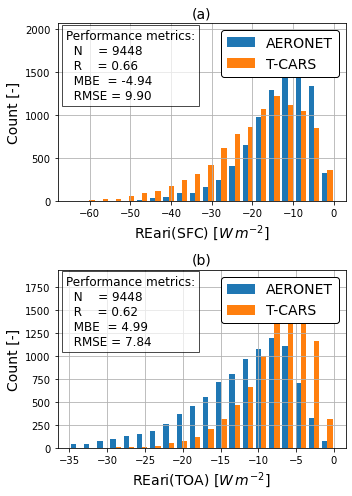

In [4]:
fig,axs = plt.subplots(2,1,figsize=(5,7))#(11,14)
fig = make_plotqq(fig=fig,
                X=XREari_sfc,
                Y=YREari_sfc,
                ax=None,ax2=axs[0],
                W='counts', # histogram of number observations
                title='(a)',
                title2='(a)',
                Xlabel='AERONET',
                Ylabel='T-CARS',
                Wlabel='Count [-]',
                Value=r'REari(SFC) [$W\,m^{-2}$]',
                lalpha=0.7,
                xlim=(-3,3),
                xlim2=(-65,0),
                ylim=(-50,50),
                qqplot=False,
                percentiles=np.arange(0.5,100,0.5),
                histplot=True,
                metrics_loc=0)

fig = make_plotqq(fig=fig,
                X=XREari_toa,
                Y=YREari_toa,
                ax=None,ax2=axs[1],
                W='counts', # histogram of number observations
                title='(a)',
                title2='(b)',
                Xlabel='AERONET',
                Ylabel='T-CARS',
                Wlabel='Count [-]',
                Value=r'REari(TOA) [$W\,m^{-2}$]',
                lalpha=0.7,
                xlim=(-3,3),
                xlim2=(-35,0),
                ylim=(-50,50),
                qqplot=False,
                percentiles=np.arange(0.5,100,0.5),
                histplot=True,
                metrics_loc=0)
plt.tight_layout()
fig.savefig("figures/test_Fig07.pdf",dpi=300,bbox_inches='tight')